# Kona Coffee Berry Classification

## Introduction

As a project assignment for the IBM Machine Learning Classification course, I decided to build my own dataset for a project that I am actually volunteering for at a local business. You can read about it here: [Kona Coffee Project Intro](https://jackmead515.github.io/notebooks/kona_coffee_intro.html). The goal of this project is to build a model that can classify coffee berries in there different lifecycles. In the local community of Kailua Kona, the coffee growers grow amazing coffee without many tools. Most of it is past down knowledge from generation to generation. But coffee leaf rust and the berry borer bettle have been creating significant damage to the coffee crops in recent years and it may be time for that to change. This project may provide a useful tool for farmers to help them identify the best time to harvest their coffee.

## Dataset

The dataset that I gathered is meerly a small sample set of a much larger dataset that has to be captured, but should display the challenges with classification that are required. I have gathered several hundred labeled instance masks of coffee berries where the images were captured without destorying the tree itself. I then classified all the berries by their lifecycle stage.

In this notebook, we will use different computer vision techniques to select features from the instance masks and experiment with different classification techniques to see which one works best for this problem.

In [2]:
import cv2
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
df = pd.read_csv('../../../kona_coffee/pipeline/classified.csv')

df['image'] = df['image'].apply(lambda x: os.path.join(os.path.abspath('../../../kona_coffee/data/augmented'), os.path.basename(x)))
df['mask'] = df['mask'].apply(lambda x: os.path.join(os.path.abspath('../../../kona_coffee/data/masks'), os.path.basename(x)))

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      453 non-null    object
 1   x          453 non-null    int64 
 2   y          453 non-null    int64 
 3   mask       453 non-null    object
 4   lifecycle  453 non-null    object
dtypes: int64(2), object(3)
memory usage: 17.8+ KB


In [4]:
df.head()

,image,x,y,mask,lifecycle
0,/home/jack/Documents/Workspace/kona_coffee/dat...,320,248,/home/jack/Documents/Workspace/kona_coffee/dat...,unripe_green
1,/home/jack/Documents/Workspace/kona_coffee/dat...,228,160,/home/jack/Documents/Workspace/kona_coffee/dat...,ripening
2,/home/jack/Documents/Workspace/kona_coffee/dat...,372,361,/home/jack/Documents/Workspace/kona_coffee/dat...,unripe_green
3,/home/jack/Documents/Workspace/kona_coffee/dat...,239,83,/home/jack/Documents/Workspace/kona_coffee/dat...,unknown
4,/home/jack/Documents/Workspace/kona_coffee/dat...,336,274,/home/jack/Documents/Workspace/kona_coffee/dat...,unknown


The image is the full 400x400 image where the berry was found. The mask is a numpy file with the mask of the berry. The mask is a 400x400 numpy array with the berry pixels set to 1 and the background set to 0. And the lifecycle is the classification of the lifecycle stage of the berry. We will ignore the x and y columns as these are not required for this project.

In [5]:
df['lifecycle'].value_counts()

lifecycle
unripe_yellow    215
unripe_green     129
ripening          53
unknown           41
ripe              15
Name: count, dtype: int64

We can see from the dataset, that the distribution between the classes is unbalanced. We may consider using some upsampling or downsampling techniques to balance the dataset.

Let's now using some machine vision techniques to extract features from the images.

In [6]:
def get_display_image(row):
    """
    Get the display image for the mask. Crops the image to the mask.
    """
    cv2image = cv2.imread(row.image)

    mask = np.load(row.mask)
    mask = mask.astype(np.uint8)
    
    # apply the mask to the image
    mask_image = cv2.bitwise_and(cv2image, cv2image, mask=mask)
    
    # crop the image to the mask
    mask_image = mask_image[np.ix_(mask.any(1),mask.any(0))]
    
    return mask_image

def get_image_features(image):
    """
    Manually extract features from the image
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    hue = image[:,:,0]
    sat = image[:,:,1]
    val = image[:,:,2]
    
    # other features to consider: 

    hue_mean = np.mean(hue)
    hue_std = np.std(hue)
    sat_mean = np.mean(sat)
    sat_std = np.std(sat)
    val_mean = np.mean(val)
    val_std = np.std(val)
    
    return hue_mean, hue_std, sat_mean, sat_std, val_mean, val_std

In [49]:
fdf = []

for row in df.itertuples():
    image = get_display_image(row)
    features = get_image_features(image)
    fdf.append([row.lifecycle, *features])

fdf = pd.DataFrame(fdf, columns=['lifecycle', 'hue_mean', 'hue_std', 'sat_mean', 'sat_std', 'val_mean', 'val_std'])

fdf

,lifecycle,hue_mean,hue_std,sat_mean,sat_std,val_mean,val_std
0,unripe_green,25.661438,15.507338,85.630065,63.279464,132.239869,88.639606
1,ripening,13.905285,8.567265,141.791695,88.370431,98.203844,69.007482
2,unripe_green,21.627079,11.818203,112.836279,66.935782,56.565229,53.630855
3,unknown,16.407490,9.329074,136.346726,76.255203,27.428571,16.705961
4,unknown,15.020235,7.263568,151.945748,72.019904,48.724047,40.188870
...,...,...,...,...,...,...,...
448,unripe_green,28.086508,12.805058,144.680952,66.704500,70.873016,36.180606
449,unripe_yellow,16.557610,10.313587,139.610775,89.566362,135.203414,97.068071
450,unripe_green,22.479263,11.505750,117.815668,69.069371,164.964055,95.501517
451,ripening,16.005556,14.003013,115.294709,70.472689,112.221429,77.853895


Now we have our first dataset to explore containing the features and the lifecycle class. Let's explore the dataset a bit and see if some graphical analysis can help us understand the data better.

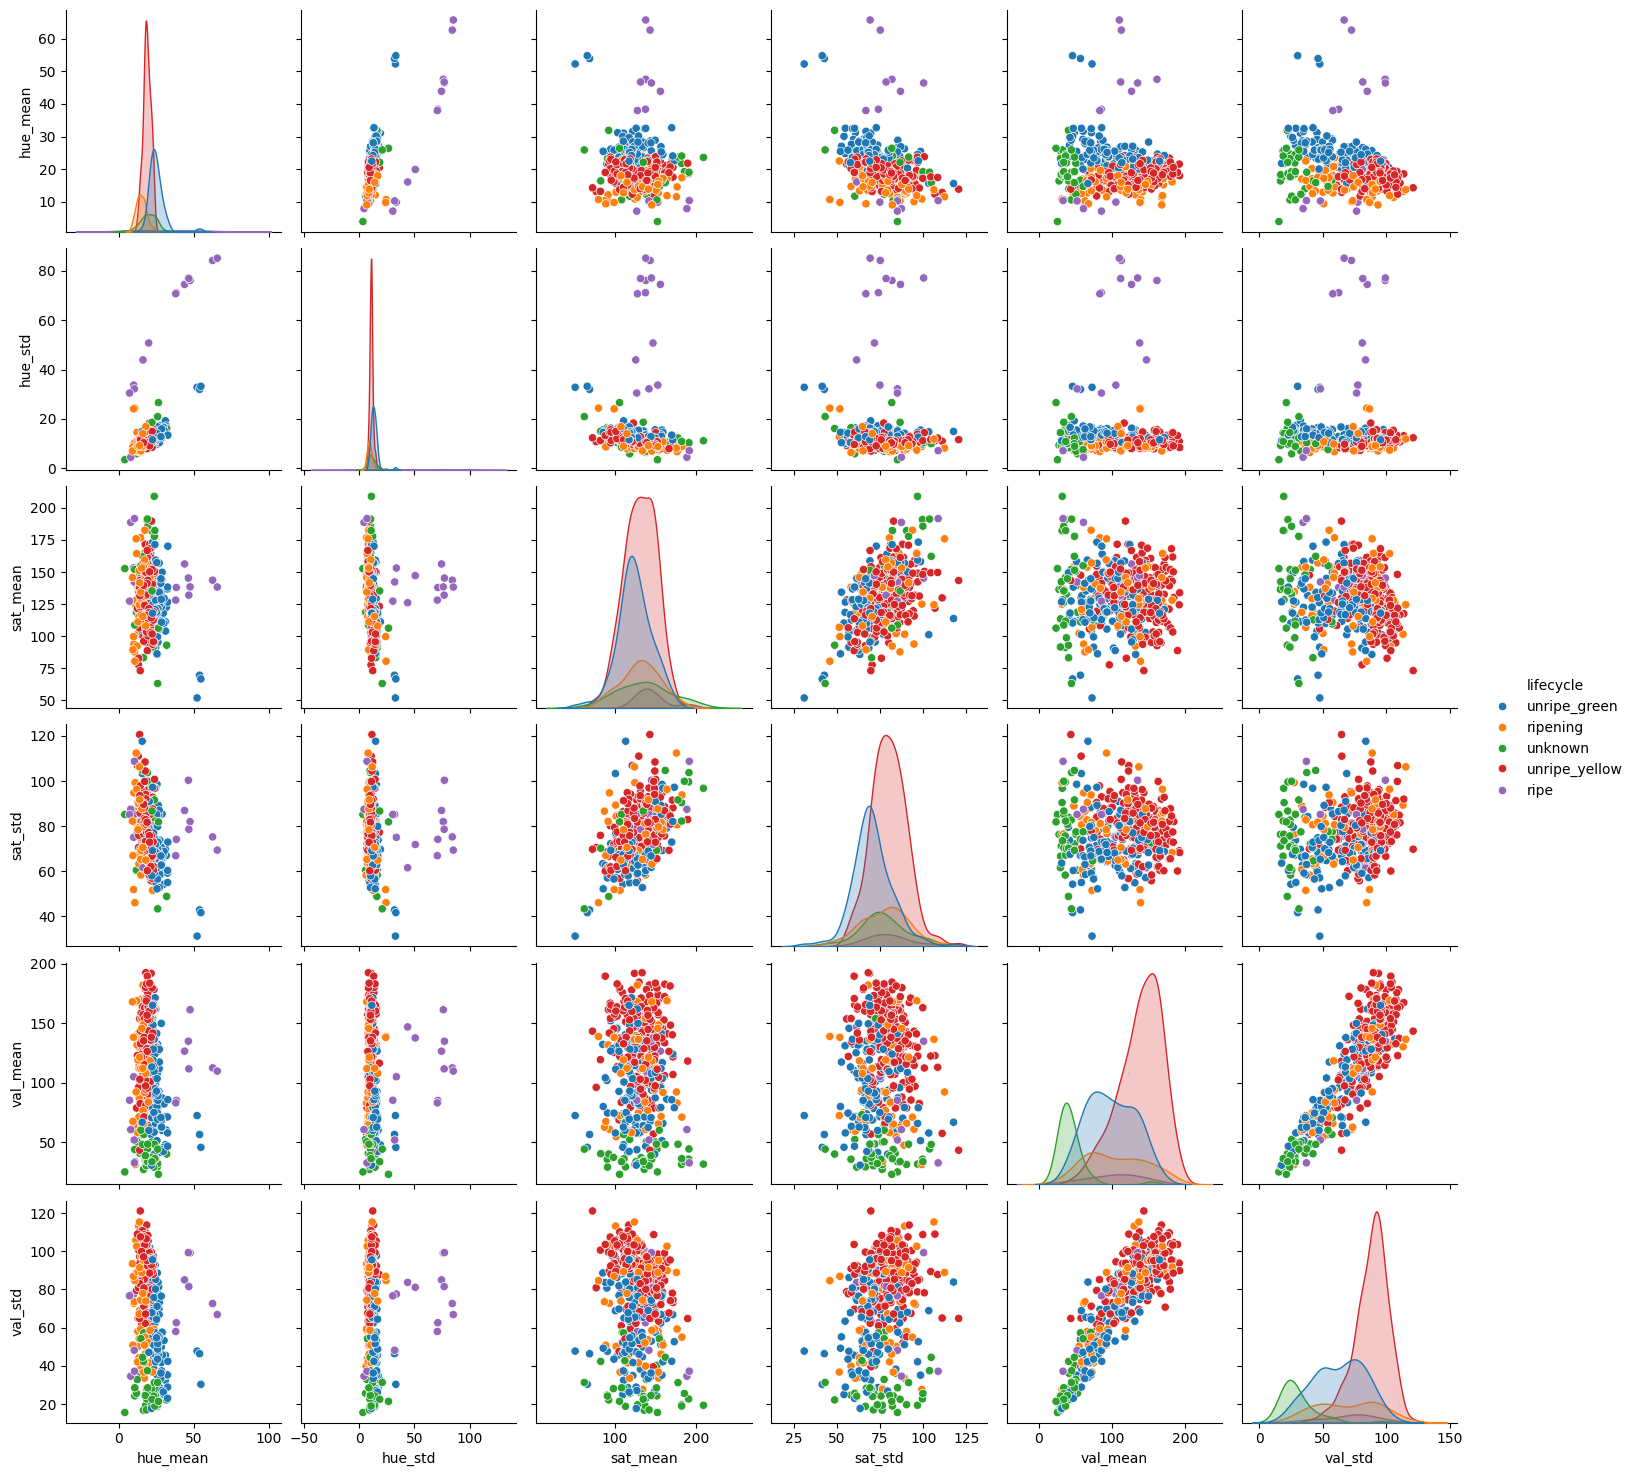

In [8]:
sns.pairplot(fdf, hue='lifecycle')

Very interesting feature space. There is certainly a lot of overlap between each lifecycle of berry when observing all the features against one another. Some feature pairs seem to have a better separation than others. This might indicate that regularization may help our models to generalize better. If we look at the "ripe" lifecycle, in some plots they are plotting far away from the rest of the data. This may indicate that the "ripe" lifecycle is easier to classify than the others.

In [15]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def print_scores(y_true, y_pred):
    """
    Print the accuracy, precision, recall, and f1 scores
    """
    print('accuracy:', accuracy_score(y_true, y_pred))
    print('precision:', precision_score(y_true, y_pred, average='weighted'))
    print('recall:', recall_score(y_true, y_pred, average='weighted'))
    print('f1:', f1_score(y_true, y_pred, average='weighted'))


def test_model(search, x_train, x_test, y_train, y_test):
    search.fit(x_train, y_train)

    model = search.best_estimator_
    best_params = search.best_params_

    print(f'best params: {best_params}')
    print_scores(y_test, model.predict(x_test))


x = fdf.drop('lifecycle', axis=1)
y = LabelEncoder().fit_transform(fdf['lifecycle'])

x_scaled = MinMaxScaler().fit_transform(x)

random_state = 237 # not room 237... 

# We need to ensure we stratify the data so that we have a good 
# representation of each class in the training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, stratify=y, random_state=random_state)

In [10]:
# We must not forget that the data is imbalanced. We will wait to use any
# resampling techniques until we have a baseline model to compare against.

print('train:', np.bincount(y_train))
print('test:', np.bincount(y_test))

train: [ 12  42  33 103 172]
test: [ 3 11  8 26 43]


In [16]:
from sklearn.linear_model import LogisticRegression

search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=random_state),
    {
        'C': [0.1, 1, 10, 100],
    },
    cv=5,
    scoring='f1_weighted'
)

test_model(search, x_train, x_test, y_train, y_test)

best params: {'C': 100}
accuracy: 0.8241758241758241
precision: 0.8279079190204511
recall: 0.8241758241758241
f1: 0.8190944979938741


This is a great first start and we can see the precision and recall are nicely balanced giving us a above average F1 score. But, it may be too simple of a model. It's worth it to at least try a few other models to see if we can improve the F1 score.

In [18]:
from sklearn.neighbors import KNeighborsClassifier

search = GridSearchCV(
    KNeighborsClassifier(),
    {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
    },
    cv=5,
    scoring='f1_weighted'
)

test_model(search, x_train, x_test, y_train, y_test)

best params: {'n_neighbors': 5, 'weights': 'uniform'}
accuracy: 0.7362637362637363
precision: 0.7127386071485451
recall: 0.7362637362637363
f1: 0.7031007541211622


KNN seems to also been a good model for this dataset. It's descriptive power is pretty good. Given how simple it is, it would be a good choice. But let's continue.

In [19]:
from sklearn.svm import SVC

search = GridSearchCV(
    SVC(random_state=random_state),
    {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'degree': [2, 3, 4],
    },
    cv=5,
    scoring='f1_weighted'
)

test_model(search, x_train, x_test, y_train, y_test)

best params: {'C': 1, 'degree': 3, 'kernel': 'poly'}
accuracy: 0.8131868131868132
precision: 0.8075043363419582
recall: 0.8131868131868132
f1: 0.8046786161510312


The SVM model also performs similarly to the above models! The best model used the polynomial kernel with a degree of 3 and a very good F1 score. This is a decent model in terms of descriptive power and it's not too complex. It would be a good choice for this dataset.

best params: {'criterion': 'entropy', 'max_depth': 5}
accuracy: 0.7582417582417582
precision: 0.7591028019599448
recall: 0.7582417582417582
f1: 0.7443785001250093


[Text(0.5625, 0.9166666666666666, 'val_std <= 0.422\nentropy = 1.865\nsamples = 362\nvalue = [12, 42, 33, 103, 172]\nclass = ripe'),
 Text(0.2857142857142857, 0.75, 'hue_mean <= 0.264\nentropy = 1.889\nsamples = 109\nvalue = [4, 22, 32, 46, 5]\nclass = unripe_yellow'),
 Text(0.15476190476190477, 0.5833333333333334, 'val_mean <= 0.222\nentropy = 1.659\nsamples = 46\nvalue = [3, 19, 19, 0, 5]\nclass = ripening'),
 Text(0.09523809523809523, 0.4166666666666667, 'hue_mean <= 0.106\nentropy = 1.34\nsamples = 28\nvalue = [3, 5, 19, 0, 1]\nclass = unknown'),
 Text(0.047619047619047616, 0.25, 'val_mean <= 0.034\nentropy = 0.811\nsamples = 4\nvalue = [3, 0, 1, 0, 0]\nclass = unripe_green'),
 Text(0.023809523809523808, 0.08333333333333333, 'entropy = 0.0\nsamples = 1\nvalue = [0, 0, 1, 0, 0]\nclass = unknown'),
 Text(0.07142857142857142, 0.08333333333333333, 'entropy = 0.0\nsamples = 3\nvalue = [3, 0, 0, 0, 0]\nclass = unripe_green'),
 Text(0.14285714285714285, 0.25, 'hue_std <= 0.086\nentropy = 

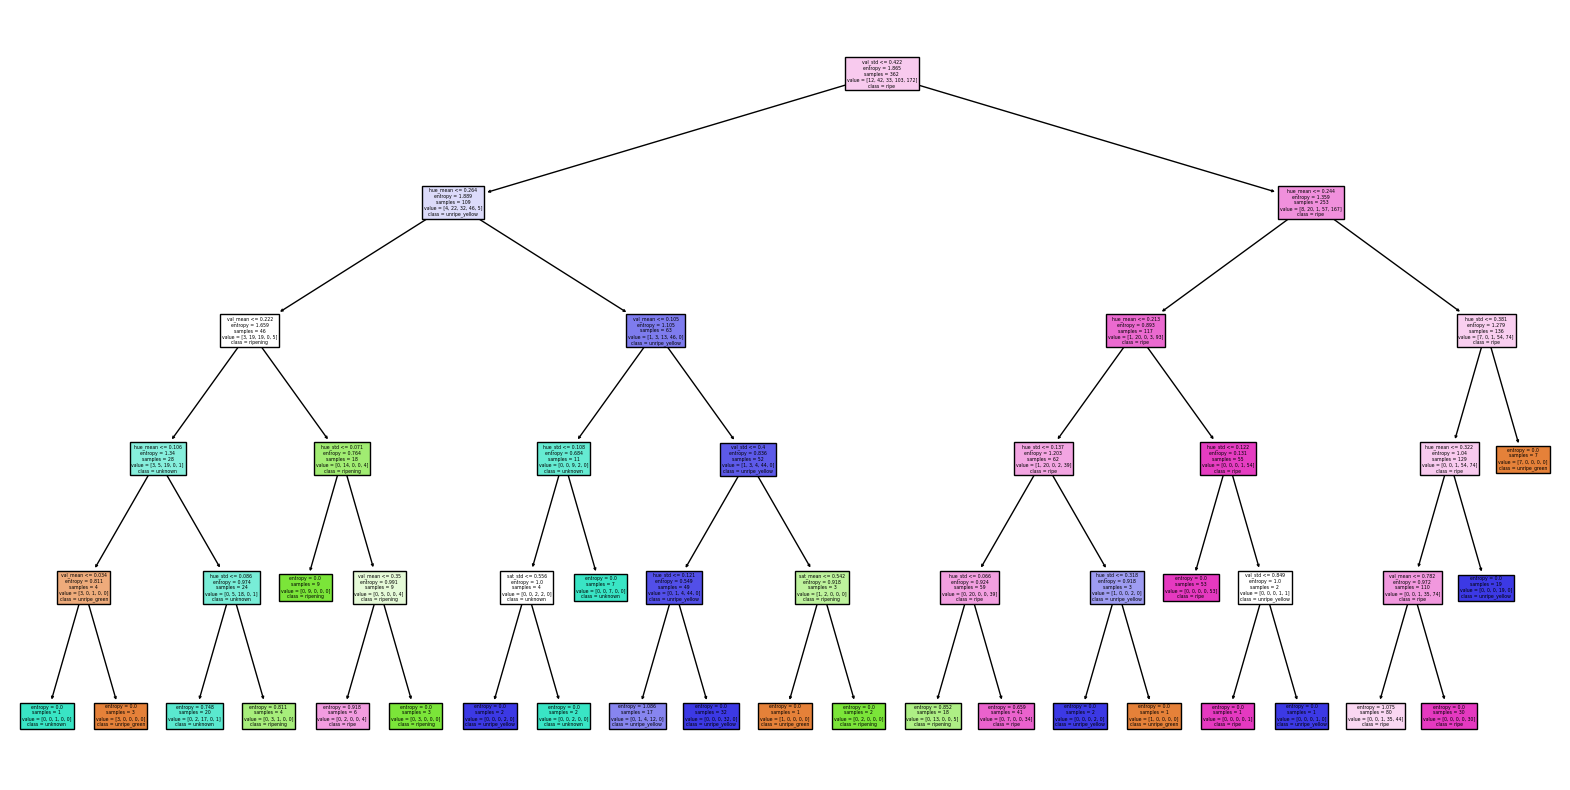

In [27]:
from sklearn.tree import DecisionTreeClassifier

search = GridSearchCV(
    DecisionTreeClassifier(),
    {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 20, 50],
    },
    cv=5,
    scoring='f1_weighted'
)

test_model(search, x_train, x_test, y_train, y_test)

from sklearn.tree import plot_tree

model = search.best_estimator_

plt.figure(figsize=(20, 10))
plot_tree(model, filled=True, feature_names=x.columns, class_names=fdf['lifecycle'].unique())

An extremely easy model, the decision tree performed well. Our precision and recall are equally balanced, but the F1 score lower than the other models. It is interesting to note that the decision trees first split is on the hue_mean. This is expected as it is the leading visual indicator of what stage the berry lifecycle is in. We will move on to some ensemble methods to see if we can improve the F1 score.

In [28]:
from sklearn.ensemble import RandomForestClassifier

search = GridSearchCV(
    RandomForestClassifier(random_state=random_state),
    {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 5, 10, 20, 50],
        'n_estimators': [10, 100, 1000],
    },
    cv=5,
    scoring='f1_weighted'
)

test_model(search, x_train, x_test, y_train, y_test)

best params: {'criterion': 'gini', 'max_depth': None, 'n_estimators': 10}
accuracy: 0.8021978021978022
precision: 0.8178863261280844
recall: 0.8021978021978022
f1: 0.7988012332228026


The random forest model certainly performed better than the decision tree model. But the grid search also took much longer! The precision and recall are nearly equally balanced.

But before going further, I want to resample the dataset to see if we can improve the F1 score.

In [29]:
from imblearn.over_sampling import SMOTE

x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, stratify=y, random_state=random_state)

x_train, y_train = SMOTE(random_state=random_state).fit_resample(x_train, y_train)

print('train:', np.bincount(y_train))
print('test:', np.bincount(y_test))

train: [172 172 172 172 172]
test: [ 3 11  8 26 43]


best params: {'n_neighbors': 3, 'weights': 'distance'}
accuracy: 0.6263736263736264
precision: 0.6081268627852479
recall: 0.6263736263736264
f1: 0.6086343185929088


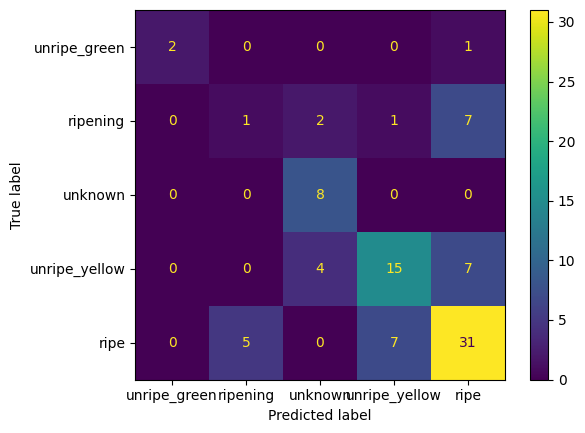

In [32]:
search = GridSearchCV(
    KNeighborsClassifier(),
    {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
    },
    cv=5,
    scoring='f1_weighted'
)

test_model(search, x_train, x_test, y_train, y_test)

from sklearn.metrics import ConfusionMatrixDisplay

model = search.best_estimator_
y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=fdf['lifecycle'].unique())
disp.plot()

After resampling our F1 score goes way down! What happened? Well, given the small dataset and the lack of proper distribution of the classes, the resampling technique may not ever be able to generalize well. One thing that I'd like to do, is just see if we can convert the lifecycle class into a smaller subset of classes. We can convert everything to be either "unripe" or "ripe". This would help to balance the classes given the small dataset.

In [50]:
# filter out unknown lifecycle
fdf = fdf[fdf['lifecycle'] != 'unknown']

# convert unripe_green, unripe_yellow to unwripe
fdf['lifecycle'] = fdf['lifecycle'].apply(lambda x: 'unripe' if x.startswith('unripe') else x)

# convert "ripe" to "ripening"
fdf['lifecycle'] = fdf['lifecycle'].apply(lambda x: 'ripening' if x == 'ripe' else x)

fdf

/tmp/ipykernel_58427/1524779578.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdf['lifecycle'] = fdf['lifecycle'].apply(lambda x: 'unripe' if x.startswith('unripe') else x)
/tmp/ipykernel_58427/1524779578.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fdf['lifecycle'] = fdf['lifecycle'].apply(lambda x: 'ripening' if x == 'ripe' else x)


,lifecycle,hue_mean,hue_std,sat_mean,sat_std,val_mean,val_std
0,unripe,25.661438,15.507338,85.630065,63.279464,132.239869,88.639606
1,ripening,13.905285,8.567265,141.791695,88.370431,98.203844,69.007482
2,unripe,21.627079,11.818203,112.836279,66.935782,56.565229,53.630855
5,unripe,25.805102,11.457008,125.744898,59.611653,132.341837,78.362843
7,ripening,10.881339,8.765141,124.865872,99.232069,31.501521,27.547074
...,...,...,...,...,...,...,...
448,unripe,28.086508,12.805058,144.680952,66.704500,70.873016,36.180606
449,unripe,16.557610,10.313587,139.610775,89.566362,135.203414,97.068071
450,unripe,22.479263,11.505750,117.815668,69.069371,164.964055,95.501517
451,ripening,16.005556,14.003013,115.294709,70.472689,112.221429,77.853895


In [57]:
fdf['lifecycle'].value_counts()

lifecycle
unripe      344
ripening     68
Name: count, dtype: int64

Still not completely balanced, but better.

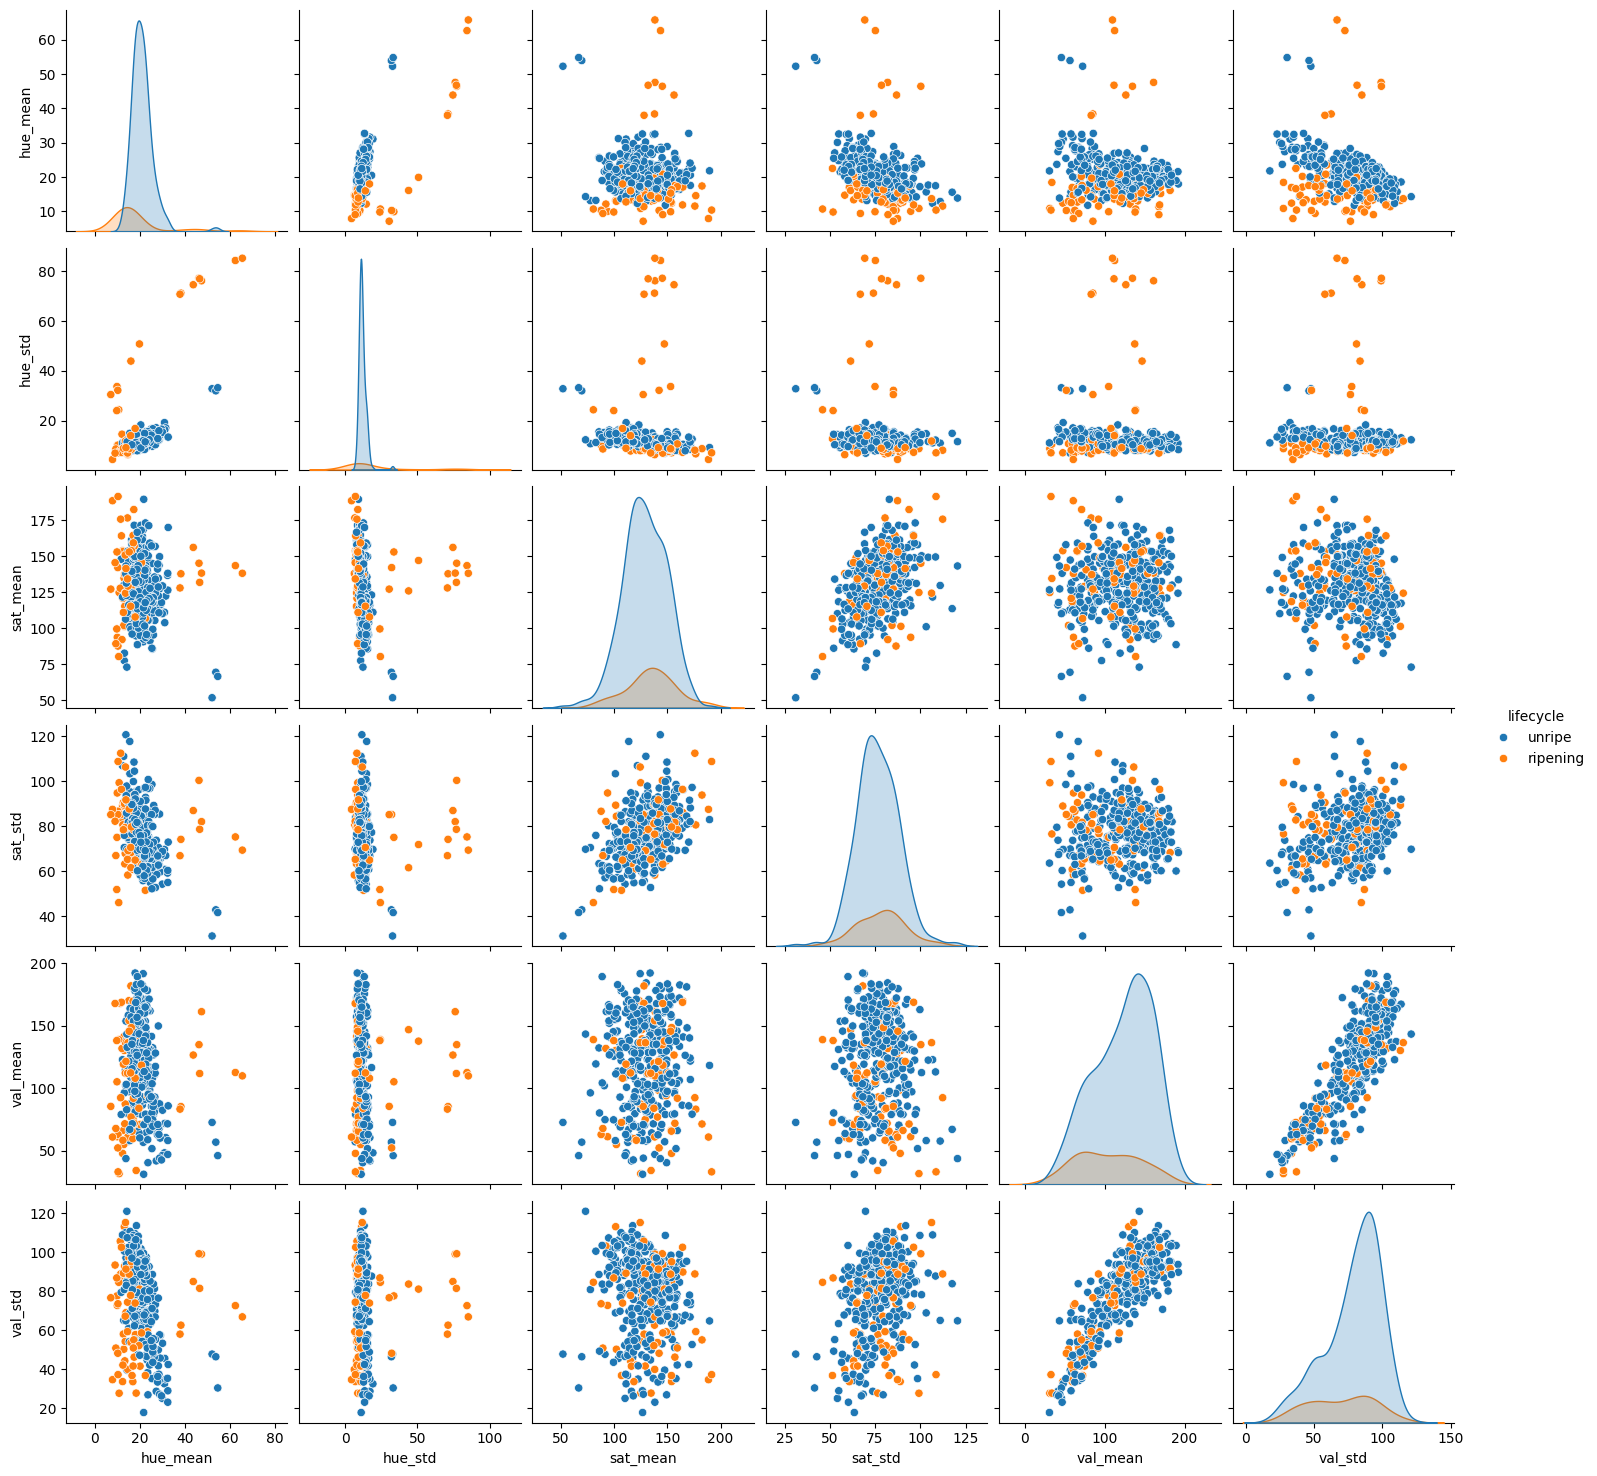

In [51]:
sns.pairplot(fdf, hue='lifecycle')

Now with this new pair plot, we can see that the "unripe" and "ripe" classes appear to be more separable than the original classes. This may help our models to generalize better. Let's try the same models as before and see if we can improve the F1 score.

In [52]:
x = fdf.drop('lifecycle', axis=1)
y = LabelEncoder().fit_transform(fdf['lifecycle'])

x_scaled = MinMaxScaler().fit_transform(x)

random_state = 237 # not room 237... 

# We need to ensure we stratify the data so that we have a good 
# representation of each class in the training and test sets
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, stratify=y, random_state=random_state)

In [55]:
search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=random_state),
    {
        'C': [0.01, 0.1, 1, 10, 100],
    },
    cv=5,
    scoring='f1_weighted'
)

test_model(search, x_train, x_test, y_train, y_test)

confusion_matrix(y_test, search.best_estimator_.predict(x_test))

best params: {'C': 100}
accuracy: 0.9518072289156626
precision: 0.9508173539227331
recall: 0.9518072289156626
f1: 0.9502978948762082


array([[11,  3],
       [ 1, 68]])

In [56]:
search = GridSearchCV(
    KNeighborsClassifier(),
    {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
    },
    cv=5,
    scoring='f1_weighted'
)

test_model(search, x_train, x_test, y_train, y_test)

confusion_matrix(y_test, search.best_estimator_.predict(x_test))

best params: {'n_neighbors': 3, 'weights': 'distance'}
accuracy: 0.891566265060241
precision: 0.8883956880152187
recall: 0.891566265060241
f1: 0.8761113419194017


array([[ 6,  8],
       [ 1, 68]])

And as expected, the F1 score improved! But as we still have a very large class imbalance, it may be worth collecting more data to see if we can improve the F1 score even more.

Finally, one last fun thing we can do instead of using machine vision techniques to get features, we can utilizing some deep learning techniques to extract features from the images.

The ResNet50 model can be converted to extract various features from images to give us much more data to work with and potentially better model generalization. It will actually give use 2048 features to anaylze!! Let's see how this works.

In [58]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tqdm import tqdm

fdf = []

# the include_top=False parameter will remove the final dense layers
# allowing us to use the features that the convolutional layers learned
# the imagenet weights load a pretrained model that has been generalized
# on many different images and many different classes.
resnet = ResNet50(
    weights='imagenet',
    include_top=False,
    pooling='avg'
)

for row in tqdm(df.itertuples(), total=len(df)):
    image = get_display_image(row)
    
    # preprocess the image for the ResNet50 model
    image = cv2.resize(image, (224, 224))
    image = preprocess_input(image)
    image = np.expand_dims(image, axis=0)
    features = resnet.predict(image, verbose=0)[0]
    
    fdf.append([row.lifecycle, features])

fdf = pd.DataFrame(fdf, columns=['lifecycle', 'features'])

fdf

100%|██████████| 453/453 [00:31<00:00, 14.25it/s]


,lifecycle,features
0,unripe_green,"[0.081668675, 0.08084484, 0.012672356, 0.21355..."
1,ripening,"[0.0, 0.6569554, 0.08572012, 0.09413268, 1.563..."
2,unripe_green,"[0.081812754, 0.50351137, 0.42483366, 0.048727..."
3,unknown,"[0.33080178, 0.10996047, 0.0, 0.4173955, 0.027..."
4,unknown,"[0.33903962, 0.2537221, 0.16390376, 0.12338973..."
...,...,...
448,unripe_green,"[0.0, 0.11975791, 0.061855286, 0.15154739, 0.0..."
449,unripe_yellow,"[0.0027795567, 0.23668365, 0.0, 0.08417456, 0...."
450,unripe_green,"[0.011270226, 1.1985146, 0.001342316, 0.082525..."
451,ripening,"[0.1427072, 1.259338, 0.15264615, 0.0, 0.09797..."


In [59]:
x = fdf['features']
x = np.stack(x, axis=0)

y = LabelEncoder().fit_transform(fdf['lifecycle'])

x_scaled = MinMaxScaler().fit_transform(x)

random_state = 237 # not room 237... 

Given the fact that 2048 features is probably too many for our dataset, let's use PCA to reduce the number of features to something more manageable.

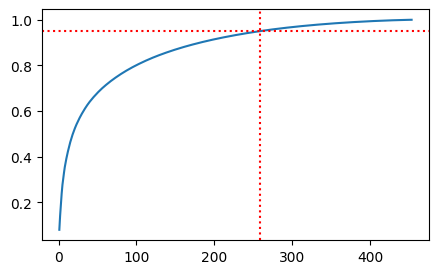

In [60]:
# import PCA
from sklearn.decomposition import PCA

# create the PCA instance
pca = PCA(random_state=random_state)

xt = pca.fit_transform(x_scaled)

cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(5, 3))
plt.plot(
    range(1, cumsum.shape[0] + 1),
    cumsum,
)
# draw horizontal line at 0.95
plt.axhline(y=0.95, color='r', linestyle=':')

# drwa vertical line where y=0.95 intersects with the curve
plt.axvline(x=np.where(cumsum >= 0.95)[0][0] + 1, color='r', linestyle=':')

As indicated by the explained variance ratio, we can reduce the number of features dramatically and still retain most of the variance in the dataset.

In [61]:
# We need to ensure we stratify the data so that we have a good 
# representation of each class in the training and test sets

pca = PCA(n_components=0.95, random_state=random_state)

xt = pca.fit_transform(x_scaled)

x_train, x_test, y_train, y_test = train_test_split(xt, y, test_size=0.2, stratify=y, random_state=random_state)

In [62]:
search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=random_state),
    {
        'C': [0.01, 0.1, 1, 10, 100],
    },
    cv=5,
    scoring='f1_weighted'
)

test_model(search, x_train, x_test, y_train, y_test)

best params: {'C': 0.1}
accuracy: 0.7362637362637363
precision: 0.736966537505621
recall: 0.7362637362637363
f1: 0.7268925518925518


In [63]:
search = GridSearchCV(
    KNeighborsClassifier(),
    {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
    },
    cv=5,
    scoring='f1_weighted'
)

test_model(search, x_train, x_test, y_train, y_test)

best params: {'n_neighbors': 3, 'weights': 'distance'}
accuracy: 0.7472527472527473
precision: 0.7787059094751402
recall: 0.7472527472527473
f1: 0.7320842676389774


Interestingly enough, our models trained on the new feature space is actually less accurate than the previous models using very basic features.

## Conclusion

Well that was a lot of fun. For me personally, building my own dataset has always been fun. It allows me to go through the entire process of machine learning to gain an intuitive sense of the entire pipeline of data collection, and just how much work it takes to build a good dataset. To collect this, I followed these basic steps:

- Went to a coffee field and took still pictures of a coffee tree with berries. This might have been the source of the large class imbalance as the tree I photographed must have been recently harvested leading to very little ripe berries.

- Converted the RAW images to PNG and cropped them to 400x400 pixels. I then used some machine vision techiniques to generate various augmented images.

- I then manually annotated every single image with a point located on each berry. I went through around 700 in about an hour! Although I must say, it was a little boring.

- Then, using my own home builted distributed kubernetes cluster and an api I builted that runs the Fast-SAM model, I ran the model on each image to generate the instance masks (validating each instance mask to ensure it properly captured the berry).

- I then manually classified each berry into the different lifecycles which proved a little challenging as some of the berries were in between stages or were simply too dark to tell.

Given that a single image can contain hundreds of berries, it's very rewarding with a few photo sessions to actually build a dataset that I can do some classification on. In the future, I will be doing more volunteer work on this and actually gathering more data and revisit this notebook for some insights for how I might approach classification in the future!